In [1]:
# Importing the required Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date, time
import joblib
# to display all columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
from pylab import rcParams
import scipy.stats as stats
from scipy.stats import chi2_contingency, chisquare, chi2
from sklearn.feature_selection import SelectFromModel

#### loading pickled dataset

In [3]:
#### loading pickled dataset ####
df_train_fe = joblib.load("df_train_fe.pkl")
df_train_fe.shape

(550068, 111)

In [4]:
#### column names
list(df_train_fe.columns)

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase',
 'Product_ID_n',
 'Product_ID_s',
 'Product_ID_Rare',
 'Product_Category_1_Rare',
 'Product_Category_2_Rare',
 'Product_Category_3_Rare',
 'Gender_le',
 'ohe_city_A',
 'ohe_city_B',
 'ohe_city_C',
 'f_product_tot_sale_amt',
 'f_product_id_m',
 'f_product_id_median',
 'f_product_id_min',
 'f_product_id_max',
 'f_product_id_std',
 'f_gender_unique_users_cnt',
 'f_age_m',
 'f_age_median',
 'f_age_std',
 'f_Age_Min',
 'f_Age_Max',
 'f_occupation_m',
 'f_occupation_tot_amt',
 'f_current_city_m',
 'f_current_city_median',
 'f_current_city_min',
 'f_current_city_max',
 'f_current_city_std',
 'f_prod_category_1_m',
 'f_prod_category_1_tot_amt',
 'f_prod_category_1_median',
 'f_prod_category_1_min',
 'f_prod_category_1_max',
 'f_prod_category_1_std',
 'f_prod_category_2_m',
 'f_prod_cate

#### FEATURE SELECTION 

In [5]:
# dropping few features 
df_train_fe = df_train_fe.drop(labels = ['User_ID', 'Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Product_Category_1',
                                        'Product_Category_2', 'Product_Category_3', 'Product_ID_n', 'Product_ID_s'], axis = 1)
print(df_train_fe.shape) 

(550068, 100)


In [6]:
# Independent & Dependent 
X_train = df_train_fe.drop(labels = ['Purchase'], axis = 1)
y_train = df_train_fe['Purchase']
print(X_train.shape) ; print(y_train.shape)

(550068, 99)
(550068,)


### 1. Filter Feature Selection Methods

#### Constant Features

In [7]:
%%time
# identify constant or Zero Variance features
from sklearn.feature_selection import VarianceThreshold
quasi_constant = VarianceThreshold(threshold= 0)
quasi_constant.fit(X_train)

Wall time: 4.96 s


VarianceThreshold(threshold=0)

In [8]:
%%time
# identifying constant columns
quasi_constant_cols = []
for col in X_train.columns :
    if col not in X_train.columns[quasi_constant.get_support()] :
        quasi_constant_cols.append(col)
        
print(len(quasi_constant_cols))
print(quasi_constant_cols)


2
['f_current_city_min', 'f_city_min']
Wall time: 261 ms
Parser   : 142 ms


In [9]:
# dropping quasi constant features
X_train = X_train.drop(labels= quasi_constant_cols, axis = 1)
print(X_train.shape)

(550068, 97)


#### Correlation Feature Selection

In [10]:
# correlation check between independent variables 
def correlation (dataset, threshold) :
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)) :
        for j in range(i) :
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr 

In [11]:
%%time
# highly correlated independent features list
highly_correlated_cols_lst = list(correlation(X_train, 0.8))
len(highly_correlated_cols_lst)

Wall time: 26.1 s


65

In [12]:
# dropping constant and highly correlated features 
independent_features_lst = []

for col in X_train.columns :
    if col not in (highly_correlated_cols_lst+quasi_constant_cols) :
        independent_features_lst.append(col)
len(independent_features_lst)

32

In [13]:
# Mutual Information Gain Feature Selection Method
#from sklearn.feature_selection import mutual_info_regression
#from sklearn.feature_selection import SelectKBest
#mutual_info = SelectKBest(mutual_info_regression, k='all')
#mutual_info = mutual_info.fit(X_train[filter_method_feature_lst], y_train)
#mutual_info_features = list(x_train.columns[selection.get_support()])
#len(mutual_info_features) 

#### ANOVA Feature Selection - Univariate Selection

In [14]:
%%time
# ANOVA Feature Selection Method
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
anova_features = SelectKBest(score_func= f_regression, k = 25)
anova_features = anova_features.fit(X_train[independent_features_lst], y_train)

Wall time: 2.35 s


In [15]:
# Anova features List
anova_features_lst = list(X_train[independent_features_lst].columns[anova_features.get_support()])
len(anova_features_lst)

25

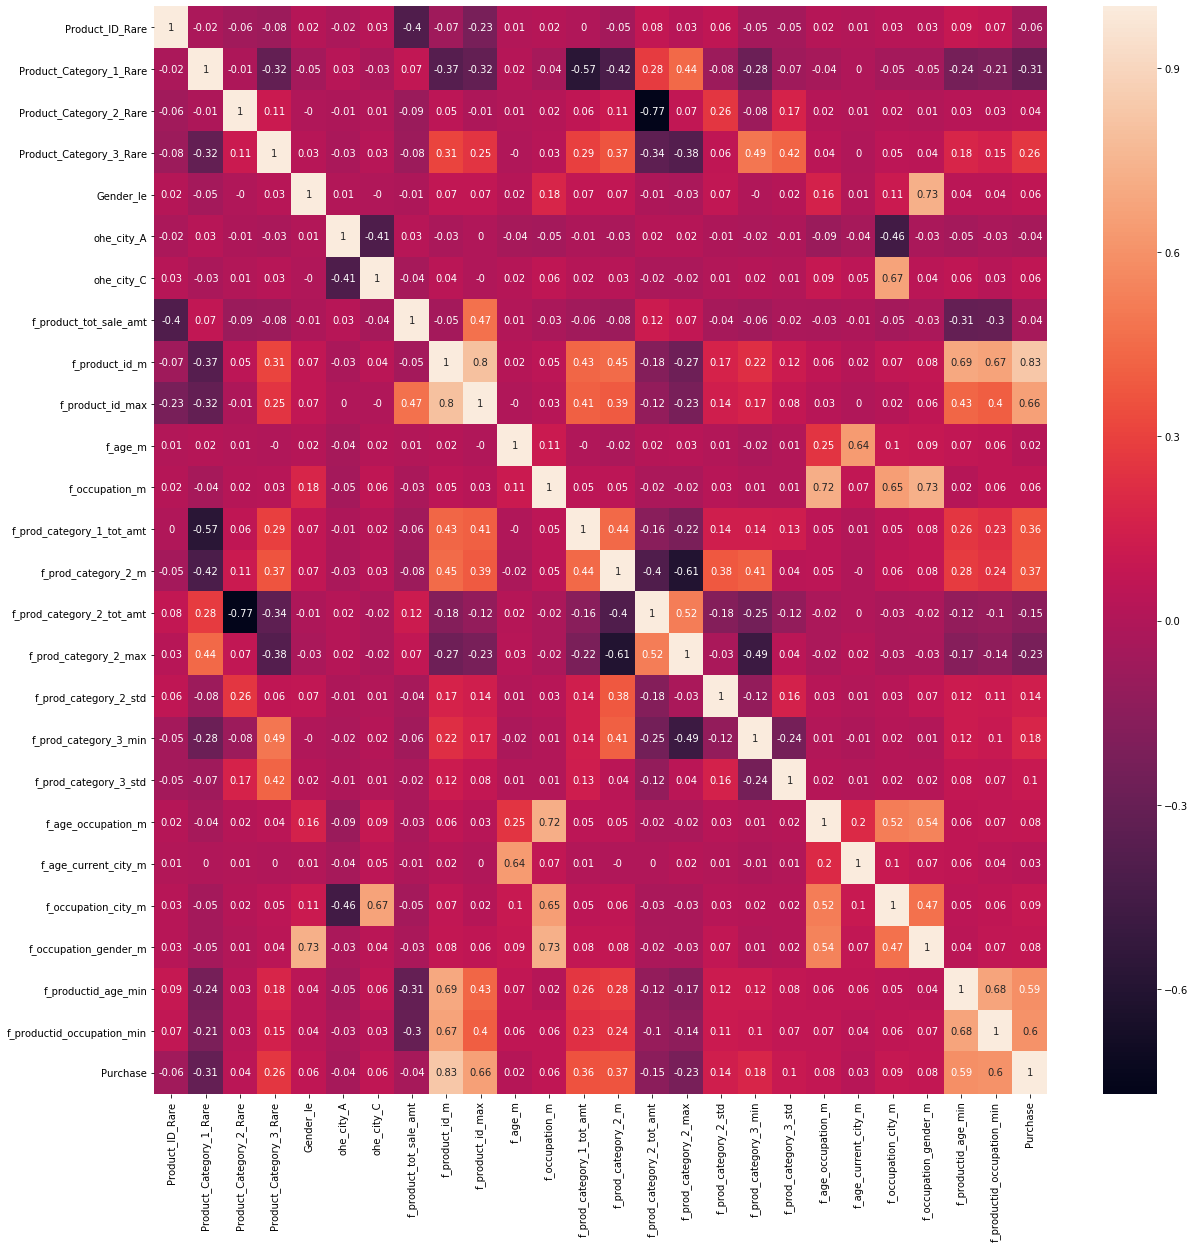

25
Wall time: 29.6 s


In [16]:
%%time
# checking correlation heatmap with target
anova_features_lst.append('Purchase')
# heatmap 
plt.figure(figsize = (20,20))
sns.heatmap(df_train_fe[anova_features_lst].corr().round(2), annot=True )
plt.show()
anova_features_lst.remove('Purchase');
print(len(anova_features_lst))

### 2. Wrapper Feature Selection Methods

#### Step Backward Selection

In [17]:
%%time
# Step Backward Selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
linear_regressor = LinearRegression()
backward_selection = SFS(estimator = linear_regressor, k_features = 25, forward = False, scoring = 'r2', cv = 3)
backward_selection = backward_selection.fit(X_train[independent_features_lst], y_train)
print("R Square of the Step Backward Selection :", backward_selection.k_score_)

R Square of the Step Backward Selection : 0.6981276553873789
Wall time: 15min 43s


In [18]:
# Step Backward Feature Selection list
bfs_features_lst = list(backward_selection.k_feature_names_)
len(bfs_features_lst)

25

#### Embedded Feature Selection Methods

#### 1. Regularization Methods - Lasso feature selection

In [71]:
%%time
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso
# define model
model = Lasso(random_state = 1)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.3, 0.7, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train[independent_features_lst], y_train)
print(results)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)                   

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000000000F6B9D30>,
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([0.3, 0.4, 0.5, 0.6])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)
MAE: -2030.682
Config: {'alpha': 0.3}
Wall time: 24min 4s


In [19]:
%%time
# Lasso feature selection implementation
from sklearn.linear_model import Lasso
lasso_select_features = SelectFromModel(Lasso(alpha = 0.3, random_state = 1))
lasso_select_features= lasso_select_features.fit(X_train[independent_features_lst], y_train)

Wall time: 1min 17s


In [20]:
# lasso features list
lasso_features_f_list = list(X_train[independent_features_lst].columns[lasso_select_features.get_support()])
len(lasso_features_f_list)

27

#### 2. Tree Based Feature Importance  Method - Random Forest Regressor

In [36]:
# parameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : np.arange(20, 101, 20),
    'criterion' : ['mse'],
    'max_depth'    : [5, 8],
    'min_samples_split': [200],
    'min_samples_leaf': [100],
    'max_features' : ['sqrt'],
    'max_leaf_nodes' : [20]
    }
# random forest regression model
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(random_state= 10)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [37]:
%%time
# Fitting the grid_search to the model ####
grid_search.fit(X_train[independent_features_lst],y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.1min finished


Wall time: 10min 24s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=10,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': 

In [38]:
# Grid Search Best Params
grid_search.best_params_
# {'criterion': 'mse', 'max_depth': 8, 'max_features': 'sqrt','max_leaf_nodes': 20,'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 20}

{'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': 20,
 'min_samples_leaf': 100,
 'min_samples_split': 200,
 'n_estimators': 20}

In [39]:
%%time
# Gradient Boosting Regressor
from sklearn.ensemble import RandomForestRegressor
rfr_features = RandomForestRegressor(random_state= 10, criterion= 'mse', max_depth= 8, max_features= 'sqrt', max_leaf_nodes= 20, min_samples_leaf= 100, min_samples_split= 200, n_estimators= 20 )
rfr_features = rfr_features.fit(X_train[independent_features_lst],y_train)

Wall time: 15.6 s


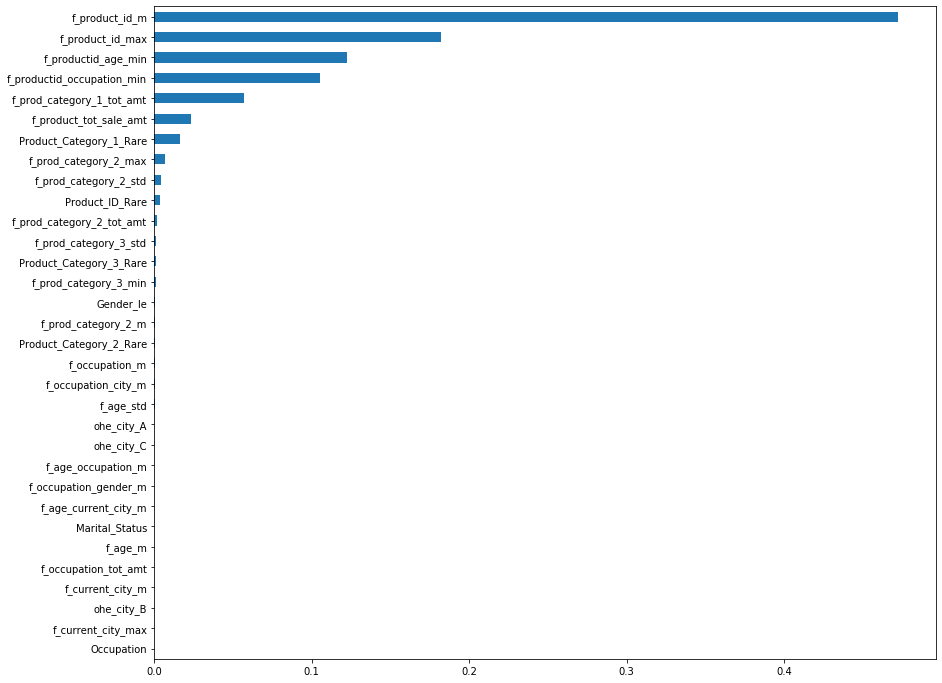

Wall time: 706 ms


In [57]:
%%time
# ranking the features importance
plt.figure(figsize= (14,12))
df_rfr_features = pd.Series(rfr_features.feature_importances_, index = X_train[independent_features_lst].columns)
df_rfr_features = df_rfr_features.sort_values(ascending = False)
df_rfr_features.sort_values(ascending = True).plot(kind = 'barh', )
plt.show()

In [60]:
# rfr_features_lst
rfr_features_lst = list(df_rfr_features[0:25].index)
len(rfr_features_lst) 

25

#### Extra Trees Regressor - Feature Selection

In [64]:
%%time
# feature importance method
from sklearn.ensemble import ExtraTreesRegressor
extratreesreg = ExtraTreesRegressor(n_estimators= 20)
extratreesreg = extratreesreg.fit(X_train[independent_features_lst], y_train)

Wall time: 4min 57s


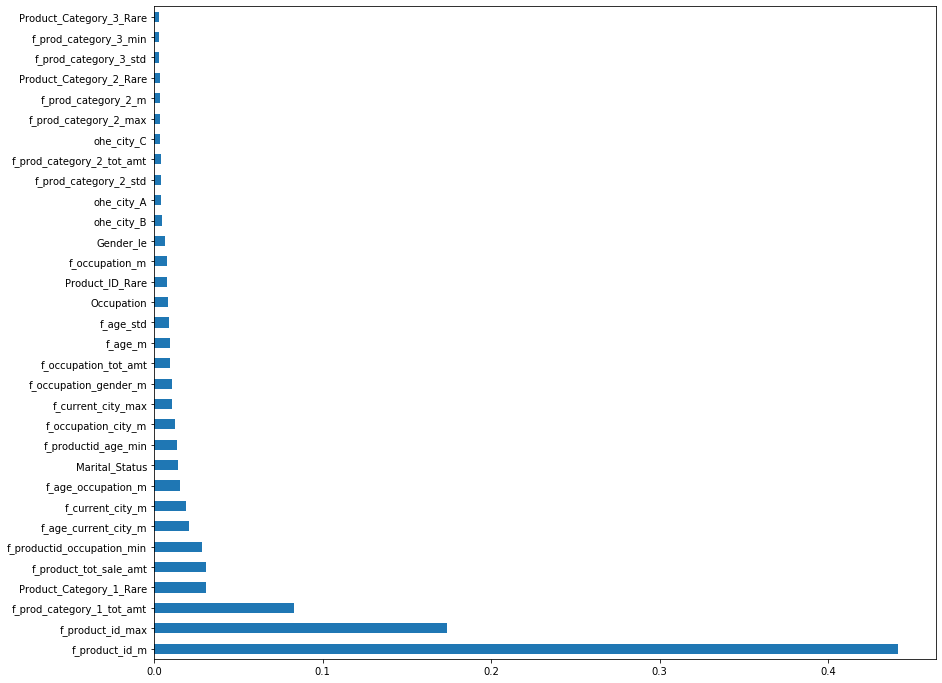

Wall time: 33.2 s


In [65]:
%%time
# ranking the features importance
plt.figure(figsize= (14,12))
extratrees_ranked_features = pd.Series(extratreesreg.feature_importances_, index = X_train[independent_features_lst].columns)
extratrees_ranked_features = extratrees_ranked_features.sort_values(ascending = False)
extratrees_ranked_features.plot(kind = 'barh')
plt.show()

In [69]:
# extratrees regressor feature importance list
extratrees_feature_lst = list(extratrees_ranked_features[0:25].index)
len(extratrees_feature_lst)

25

#### pickling

In [71]:
#### pickling the df_train_eda dataset ####
print(joblib.dump(df_train_fe, "df_train_fs.pkl"))
print(df_train_fe.shape)

['df_train_fs.pkl']
(550068, 100)


In [72]:
# Quasi-constant features
print(joblib.dump(quasi_constant_cols, 'quasi_constant_cols.pkl'))
print(len(quasi_constant_cols))

['quasi_constant_cols.pkl']
2


In [73]:
# ANOVA Features Selection List
print(joblib.dump(anova_features_lst, 'anova_features_lst.pkl'))
len(anova_features_lst)

['anova_features_lst.pkl']


25

In [74]:
# Step Backward feature selection columns
print(joblib.dump(bfs_features_lst, 'bfs_features_lst.pkl'))
len(bfs_features_lst)

['bfs_features_lst.pkl']


25

In [75]:
# lasso feature selection columns
print(joblib.dump(lasso_features_f_list, 'lasso_features_f_list.pkl'))
len(lasso_features_f_list)

['lasso_features_f_list.pkl']


27

In [76]:
# Random Forest feature importance feature selection columns
print(joblib.dump(rfr_features_lst, 'rfr_features_lst.pkl'))
len(rfr_features_lst)

['rfr_features_lst.pkl']


25

In [70]:
# ExtraTrees Feature important selection list
print(joblib.dump(extratrees_feature_lst, 'extratrees_feature_lst.pkl'))
len(extratrees_feature_lst)

['extratrees_feature_lst.pkl']


25

### Comments are appreciated to improve model performance and learning !!!